<a href="https://colab.research.google.com/github/ahhli/sene_suits/blob/main/meas_pred_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [114]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# read in data
df=pd.read_excel('/content/drive/MyDrive/Sene_suits/suits_data.xlsx', None)

# assign each sheet its own variable name (first 4 chars of the sheetname)
for names in df.keys():
  globals()[f'df_{names[:4]}']=df[names]

### Data Cleaning

In [123]:
# clean order #
df['suit measurements']['Order#']=df['suit measurements']['Order#'].apply(lambda x: str(x).split('-')[0])

In [124]:
# keep only numeric order numbers
df['suit measurements'] = df['suit measurements'][df['suit measurements']['Order#'].apply(lambda x: x.isnumeric())]

In [125]:
df['suit measurements']['Category'].unique()

array(['2 pcs Suit', 'Shirt', 'Pant', 'Women jacket', 'Women pant',
       'Jacket', 'Short Pant', 'Casual Coat', 'Overcoat',
       'Women Overcoat', 'Vest', 'Women Overcoat(L)'], dtype=object)

In [126]:
# filter by product category
df['suit measurements'] = df['suit measurements'][df['suit measurements'].Category.isin(['2 pcs Suit','Jacket', 'Pant'])]

In [127]:
# change Order Number type to 'str'

df['refunds']['Order Number'] = df['refunds']['Order Number'].astype('str')

# drop all records with order number in Refund Table

df['suit measurements'] = df['suit measurements'][~df['suit measurements']['Order#'].isin(df['refunds']['Order Number'])]

In [128]:
# fix Order# format in Remake Table
# df['remakes']['Order#'] = df['remakes']['Order#'].apply(lambda x: str(x).split('.')[0])

# drop all records with SBNY in Remake Table
df['suit measurements'] = df['suit measurements'][~df['suit measurements']['SBNY'].isin(df['remakes']['SBNY/SE'])]

In [129]:
# fix order_name format in Historical Shopify Data Table
df['historical shopify data']['order_name'] = df['historical shopify data']['order_name'].apply(lambda x: str(x).split('#')[1])

# keep records with Order Number in Shopify Data Table
df['suit measurements'] = df['suit measurements'][df['suit measurements']['Order#'].isin(df['historical shopify data']['order_name'])]

In [130]:
# convert "Create Date" to datetime format
df['suit measurements'].loc[:,'Create Date'] = pd.to_datetime(df['suit measurements'].loc[:,'Create Date'])
# Apply 60-day refundable rule
df['suit measurements'] = df['suit measurements'][df['suit measurements']['Create Date']<'2023-03-16']

<ipython-input-130-d4ef7c379d47>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df['suit measurements'].loc[:,'Create Date'] = pd.to_datetime(df['suit measurements'].loc[:,'Create Date'])


In [131]:
df['historical shopify data'].columns

Index(['day', 'order_name', 'product_title', 'product_type', 'product_id',
       'customer_id', 'customer_type', 'orders', 'gross_sales', 'discounts',
       'returns', 'net_sales', 'total_sales', 'ordered_item_quantity'],
      dtype='object')

In [132]:
# get ready to merge!
meas = df['suit measurements'][df['suit measurements']['Create Date']>'2021-12-31']
shop = df['historical shopify data'][df['historical shopify data']['customer_type']=='First-time'][['order_name','customer_id','customer_type']].drop_duplicates()
# merge!
meas = meas.merge(shop, left_on='Order#', right_on = 'order_name').drop('customer_type',axis=1)


In [133]:
meas.shape

(9730, 34)

In [134]:
# # find all first time customers and those with return orders
# fir = set(shop[shop['customer_type']=='First-time']['customer_id'])
# ret = set(shop[shop['customer_type']=='Returning']['customer_id'])
# len(ret.intersection(fir))

# # 2237 out of 3236 returning customers have records on their first order

In [135]:
# keep the last record that complies with 60-day rule for each pair of Order# and Category
fitflag = meas.groupby(['Order#','Category'])['Create Date'].idxmax().values
meas = meas.loc[fitflag]

In [136]:
# devide meas table into Jackets and Pants
jkt = pd.concat([meas[meas['Category']=='Jacket'],meas[meas['Category']=='2 pcs Suit']])
pnt = pd.concat([meas[meas['Category']=='Pant'],meas[meas['Category']=='2 pcs Suit']])

In [137]:
jkt_keep = ['Neck', 'Chest', 'Stomach', 'Seat', 'Bicep', 'Shoulder', 'Sleeve(L)', 'Front Shoulder', 'Nape',
       'Back Length', 'Front Waist Length', 'Sleeve(R)','Order#','customer_id','Create Date']

jkt = jkt[jkt_keep]

# get the max of Sleeve L and R for a new attribute "Sleeve"
jkt['Sleeve'] = jkt[['Sleeve(L)','Sleeve(R)']].max(axis=1)
jkt.drop(['Sleeve(L)','Sleeve(R)'],axis=1, inplace = True)

In [138]:
pnt_keep = ['Pants Waist', 'Pants Seat', 'Thigh', 'U-Rise', 'Front Waist Height',
       'Back Waist Height', 'Outseam(L)', 'Knee', 'Cuff', 'Outseam(R)',
       'Order#','customer_id','Create Date']

pnt = pnt[pnt_keep]

# get the max of Sleeve L and R for a new attribute "Sleeve"
pnt['Outseam'] = pnt[['Outseam(L)','Outseam(R)']].max(axis=1)
pnt.drop(['Outseam(L)','Outseam(R)'],axis=1, inplace = True)

In [139]:
# 438 records has missing values in Knee, will drop
pnt = pnt.dropna()
jkt = jkt.dropna()

### Bring in the quiz data

In [140]:
# get unique customer ID from Shopify Table

custID = df['historical shopify data'][df['historical shopify data']['order_name'].isin(df['suit measurements']['Order#'])]['customer_id'].unique()

In [141]:
# get Quiz records with the same customer ID
quiz = df['historical quiz data'][df['historical quiz data']['customer id'].isin(custID)]
quiz = quiz[quiz['gender']=='men'][['customer id','answers','created_at']]

In [142]:
# convert "create_at" data type to datetime
quiz['created_at'] = pd.to_datetime(quiz['created_at'])
quiz['quiz_date'] = quiz['created_at'].dt.date
df['historical shopify data']['day'] = pd.to_datetime(df['historical shopify data']['day'])

In [143]:
# merge!!
jkt_q = jkt.merge(quiz, left_on='customer_id', right_on='customer id')
pnt_q = pnt.merge(quiz, left_on='customer_id', right_on='customer id')

In [144]:
# calculate the difference between quiz and measurement created date
jkt_q['gap'] = (jkt_q['Create Date'].dt.date-jkt_q['quiz_date']).dt.days
pnt_q['gap'] = (pnt_q['Create Date'].dt.date-pnt_q['quiz_date']).dt.days

In [145]:
# select the record with the least positive gap for each order number
jktfl = jkt_q[jkt_q['gap']>=0]
jktflag = jktfl.groupby('Order#')['gap'].idxmin()
# only unique order is included for training
jset = jktfl.loc[jktflag]
print('Possible occurence of each Order #: {}'.format(jset['Order#'].value_counts().unique()))

Possible occurence of each Order #: [1]


In [146]:
# repeat for pants dataset
# select the record with the least positive gap for each order number
pntfl = pnt_q[pnt_q['gap']>=0]
pntflag = pntfl.groupby('Order#')['gap'].idxmin()
# only unique order is included for training
pset = pntfl.loc[pntflag]
print('Possible occurence of each Order #: {}'.format(pset['Order#'].value_counts().unique()))

Possible occurence of each Order #: [1]


In [147]:
# change measurement datatype to float

pset[pset.columns[:8]] = pset[pset.columns[:8]].astype('float')
jset[jset.columns[:10]] = jset[jset.columns[:10]].astype('float')

### Expand Quiz Answer

In [148]:
# expand answers
jqz = jset['answers'].apply(lambda x: pd.Series(eval(x)))
# check the values in each answer field and discard all field with only 1 value
drop_flag = []
for col in jqz.columns:
  if jqz[col].nunique()<2:
    print(col,":",jqz[col].nunique(), '\n', jqz[col].unique())
    drop_flag.append(col)

jqz.drop(drop_flag,axis=1,inplace=True)

jqz.shape
# check missing values
jqz.isna().sum()
# "acquisition_channel" can be dropped
# "How did you first hear about us?" can be dropped
# "updated_at" can be dropped

jqz.drop(["acquisition_channel","How did you first hear about us?","updated_at"],axis = 1, inplace = True)

qz1 = jqz.iloc[:,:13]
cls = ['height', 'weight', 'rise', 'build', 'm_tops_length', 'midsection',
       'pant_break', 'shoulder_slope', 'm_pants_waist','m_pants_inseam' ,'seat_shape',  'm_tops_fit',
        'shoulder_rotation']
cls.extend(jqz.columns[13:])
jqz = jqz[cls]
jqz.loc[~jqz['How tall are you?'].isna(),jqz.columns[:13]] = jqz.loc[~jqz['How tall are you?'].isna(),jqz.columns[13:]].values
jset_f = pd.concat([jset,jqz.iloc[:,:13]],axis=1).drop('answers',axis=1)
jset_f.drop(['Order#','customer_id', 'Create Date','customer id', 'created_at','quiz_date', 'gap'],axis=1,inplace= True)
jset_f.columns
jset_f = jset_f.replace('',np.nan)
# drop records missing height or weight
# jset_f = jset_f[~((jset_f.height.isna()) | (jset_f.weight.isna()))]
# change all missing values in other attributes to "Skipped"
jset_f = jset_f.fillna('Skipped')
# clean the values
for col in jset_f.columns[11:]:
  # change all "not sure" or "no answer" to "Skipped"
  jset_f.loc[jset_f[col].str.contains("sure|skip", case = False),col] = 'Skipped'
  # remove white spaces before and after
  jset_f[col] = jset_f[col].apply(lambda x: x.strip())
  # remove the comma after a value
  jset_f[col] = jset_f[col].apply(lambda x: x.split(',')[0])

# convert height to cm
def conv(x):
  if len(x.split()) == 4:
    res = round((float(x.split('ft')[0])*12+float(x.split('ft')[1].split('in')[0]))*2.54,2)
  elif len(x.split()) == 2:
    res = round(float(x.split('ft')[0])*12*2.54,2)
  elif x.isnumeric():
    res = round(float(x)*2.54,2)
  else:
    res = x
  return res

# convert!
jset_f.height = jset_f.height.apply(conv)
# clean values in weight
# remove 'lbs'
jset_f['weight'] = jset_f['weight'].apply(lambda x: x.split('lbs')[0])
jset_f['weight'] = jset_f['weight'].apply(lambda x: x.split('lb')[0])
# change '-' to skipped
jset_f.loc[jset_f['weight']=='-','weight'] = 'Skipped'
# remove missing weight and height
# jset_f = jset_f[~((jset_f.weight == 'Skipped')|(jset_f.height == 'Skipped'))]

jset_f.loc[jset_f['pant_break'].str.contains("Slight Break", case = False),'pant_break'] = 'Slight Break'

notes : 1 
 ['' nan None]
w_bra_cup : 1 
 ['' nan None]
w_bra_band : 1 
 ['' nan None]
w_chest_fit : 1 
 ['' nan None]
w_tops_size : 1 
 ['' nan None]
m_shirt_cuff : 1 
 ['' nan None]
w_calves_fit : 1 
 ['' nan None]
m_blazer_size : 1 
 ['' nan None]
w_bottoms_fit : 0 
 [nan]
w_jeans_waist : 1 
 ['' nan None]
w_bottoms_size : 1 
 ['' nan None]
m_blazer_length : 1 
 ['' nan None]
w_shoulders_fit : 1 
 ['' nan None]
w_hip_measurement : 1 
 ['' nan None]
w_tops_length_fit : 1 
 ['' nan None]
w_knee_measurement : 1 
 ['' nan None]
w_bottoms_waist_fit : 1 
 ['' nan None]
w_sleeve_length_fit : 1 
 ['' nan None]
w_thigh_measurement : 1 
 ['' nan None]
w_waist_measurement : 1 
 ['' nan None]
w_ankles_measurement : 1 
 ['' nan None]
w_bottoms_length_fit : 1 
 ['' nan None]
w_calves_measurement : 1 
 ['' nan None]
w_inseam_measurement : 1 
 ['' nan None]
w_outseam_measurement : 1 
 ['' nan None]
w_front_rise_measurement : 1 
 ['' nan None]


In [149]:
# repeat for pants
# expand answers
pqz = pset['answers'].apply(lambda x: pd.Series(eval(x)))
# check the values in each answer field and discard all field with only 1 value
drop_flag = []
for col in pqz.columns:
  if pqz[col].nunique()<2:
    print(col,":",pqz[col].nunique(), '\n', pqz[col].unique())
    drop_flag.append(col)

pqz.drop(drop_flag,axis=1,inplace=True)

pqz.shape
# check missing values
pqz.isna().sum()
# "acquisition_channel" can be dropped
# "How did you first hear about us?" can be dropped
# "updated_at" can be dropped

pqz.drop(["acquisition_channel","How did you first hear about us?","updated_at"],axis = 1, inplace = True)

qz1 = pqz.iloc[:,:13]
cls = ['height', 'weight', 'rise', 'build', 'm_tops_length', 'midsection',
       'pant_break', 'shoulder_slope', 'm_pants_waist','m_pants_inseam' ,'seat_shape',  'm_tops_fit',
        'shoulder_rotation']
cls.extend(pqz.columns[13:])
pqz = pqz[cls]
pqz.loc[~pqz['How tall are you?'].isna(),pqz.columns[:13]] = pqz.loc[~pqz['How tall are you?'].isna(),pqz.columns[13:]].values
pset_f = pd.concat([pset,pqz.iloc[:,:13]],axis=1).drop('answers',axis=1)
pset_f.drop(['Order#','customer_id', 'Create Date','customer id', 'created_at','quiz_date', 'gap'],axis=1,inplace= True)
pset_f.columns
pset_f = pset_f.replace('',np.nan)


notes : 1 
 ['' nan None]
w_bra_cup : 1 
 ['' nan None]
w_bra_band : 1 
 ['' nan None]
w_chest_fit : 1 
 ['' nan None]
w_tops_size : 1 
 ['' nan None]
m_shirt_cuff : 1 
 ['' nan None]
w_calves_fit : 1 
 ['' nan None]
m_blazer_size : 1 
 ['' nan None]
w_bottoms_fit : 0 
 [nan]
w_jeans_waist : 1 
 ['' nan None]
w_bottoms_size : 1 
 ['' nan None]
m_blazer_length : 1 
 ['' nan None]
w_shoulders_fit : 1 
 ['' nan None]
w_hip_measurement : 1 
 ['' nan None]
w_tops_length_fit : 1 
 ['' nan None]
w_knee_measurement : 1 
 ['' nan None]
w_bottoms_waist_fit : 1 
 ['' nan None]
w_sleeve_length_fit : 1 
 ['' nan None]
w_thigh_measurement : 1 
 ['' nan None]
w_waist_measurement : 1 
 ['' nan None]
w_ankles_measurement : 1 
 ['' nan None]
w_bottoms_length_fit : 1 
 ['' nan None]
w_calves_measurement : 1 
 ['' nan None]
w_inseam_measurement : 1 
 ['' nan None]
w_outseam_measurement : 1 
 ['' nan None]
w_front_rise_measurement : 1 
 ['' nan None]


In [150]:

# drop records missing height or weight
# pset_f = pset_f[~((pset_f.height.isna()) | (pset_f.weight.isna()))]
# change all missing values in other attributes to "Skipped"
pset_f = pset_f.fillna('Skipped')
# clean the values
for col in pset_f.columns[9:]:
  # change all "not sure" or "no answer" to "Skipped"
  pset_f.loc[pset_f[col].str.contains("sure|skip", case = False),col] = 'Skipped'
  # remove white spaces before and after
  pset_f[col] = pset_f[col].apply(lambda x: x.strip())
  # remove the comma after a value
  pset_f[col] = pset_f[col].apply(lambda x: x.split(',')[0])
# convert height to cm
def conv(x):
  if len(x.split()) == 4:
    res = round((float(x.split('ft')[0])*12+float(x.split('ft')[1].split('in')[0]))*2.54,2)
  elif len(x.split()) == 2:
    res = round(float(x.split('ft')[0])*12*2.54,2)
  elif x.isnumeric():
    res = round(float(x)*2.54,2)
  else:
    res = x
  return res

# convert!
pset_f.height = pset_f.height.apply(conv)
# clean values in weight
# remove 'lbs'
pset_f['weight'] = pset_f['weight'].apply(lambda x: x.split('lbs')[0])
# change '-' to skipped
pset_f.loc[pset_f['weight']=='-','weight'] = 'Skipped'

pset_f.loc[pset_f['pant_break'].str.contains("Slight Break", case = False),'pant_break'] = 'Slight Break'

# Prepare Dataset

In [151]:
print(f"there is {jset_f.isna().sum().sum()} missing values in Jackets attributes")
print(f"there is {pset_f.isna().sum().sum()} missing values in Pants attributes")

there is 0 missing values in Jackets attributes
there is 0 missing values in Pants attributes


In [152]:
for col in jset_f.columns[11:]:
  print(jset_f[col].value_counts())

177.8      1000
180.34      891
182.88      837
175.26      824
172.72      652
185.42      636
187.96      559
170.18      455
190.5       337
193.04      268
167.64      264
165.1       141
195.58      127
162.56       72
198.12       48
160.02       28
200.66       28
157.48       17
203.2        17
154.94        8
Skipped       5
152.4         4
205.74        4
208.28        3
213.36        1
210.82        1
Name: height, dtype: int64
200      328
190      308
185      302
180      275
195      272
        ... 
328        1
426        1
296        1
127.2      1
241        1
Name: weight, Length: 224, dtype: int64
Normal-rise     5498
Low-rise        1002
Skipped          400
High-waisted     327
Name: rise, dtype: int64
Rhomboid     2903
Rectangle    2083
Oval         1261
Triangle      481
Pear          435
Skipped        64
Name: build, dtype: int64
Length Just Right    2418
Skipped              2088
Too Short            1460
Too Long             1261
Name: m_tops_length, dtype:

In [153]:
jset_f.columns

Index(['Neck', 'Chest', 'Stomach', 'Seat', 'Bicep', 'Shoulder',
       'Front Shoulder', 'Nape', 'Back Length', 'Front Waist Length', 'Sleeve',
       'height', 'weight', 'rise', 'build', 'm_tops_length', 'midsection',
       'pant_break', 'shoulder_slope', 'm_pants_waist', 'm_pants_inseam',
       'seat_shape', 'm_tops_fit', 'shoulder_rotation'],
      dtype='object')

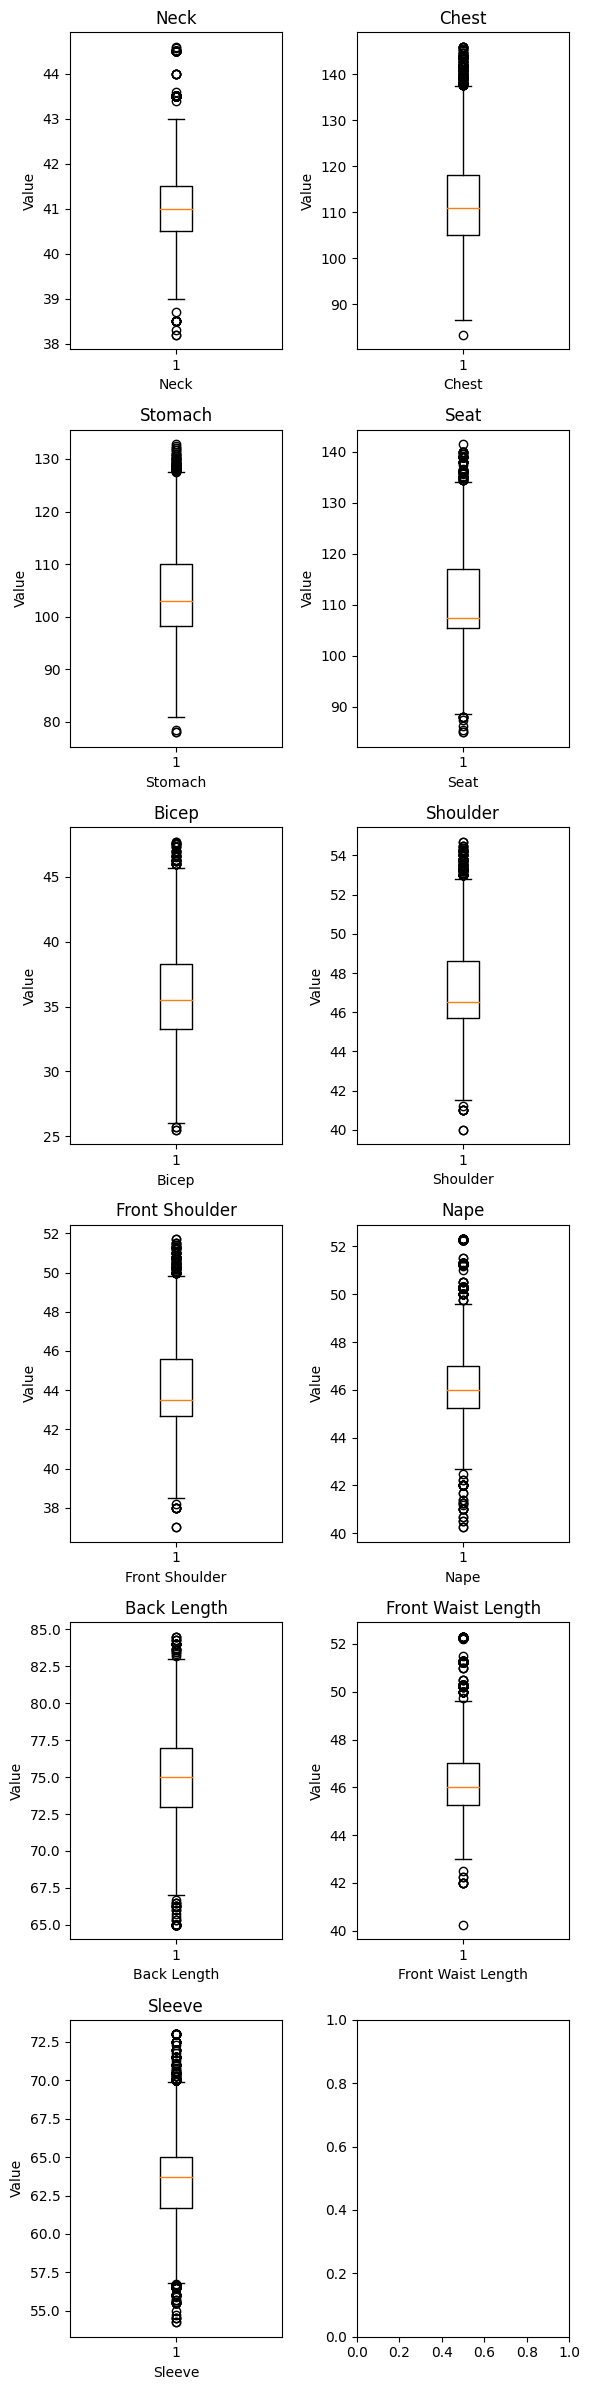

In [155]:
# remove outliers
from scipy import stats
cols=['Neck', 'Chest', 'Stomach', 'Seat', 'Bicep', 'Shoulder',
       'Front Shoulder', 'Nape', 'Back Length', 'Front Waist Length', 'Sleeve']

z_scores = np.abs(stats.zscore(jset_f[cols]))
threshold = 3
jset_f = jset_f[(z_scores < threshold).all(axis=1)]

fig, axs = plt.subplots(6, 2, figsize=(6, 24))
for i, var in enumerate(cols):
    row, col = divmod(i, 2)
    axs[row, col].boxplot(jset_f[var])
    axs[row, col].set_title(var)
    axs[row, col].set_xlabel(var)
    axs[row, col].set_ylabel('Value')


plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()

In [110]:
# # alternatively, features can be converted to float datatype

# jset_f = jset_f[(jset_f.height!='Skipped') & (jset_f.weight!='Skipped')]
# jset_f['height'] = jset_f['height'].astype('float')
# jset_f['weight'] = jset_f['weight'].astype('float')

In [156]:
jset_f.describe()

,Neck,Chest,Stomach,Seat,Bicep,Shoulder,Front Shoulder,Nape,Back Length,Front Waist Length,Sleeve
count,6808.000000,6808.000000,6808.000000,6808.000000,6808.000000,6808.000000,6808.000000,6808.000000,6808.000000,6808.000000,6808.000000
mean,41.307731,112.598716,104.636820,111.066222,35.816272,47.218834,44.222835,46.502305,74.575965,46.569702,63.524189
std,1.029341,10.073947,8.696615,9.478691,3.710515,2.390974,2.393702,2.067975,3.278010,2.034126,3.130933
min,38.200000,83.300000,78.000000,85.000000,25.500000,40.000000,37.000000,40.250000,65.000000,40.250000,54.250000
25%,40.500000,105.000000,98.300000,105.500000,33.300000,45.700000,42.700000,45.250000,73.000000,45.250000,61.700000
50%,41.000000,111.000000,103.000000,107.500000,35.500000,46.500000,43.500000,46.000000,75.000000,46.000000,63.700000
75%,41.500000,118.000000,110.000000,117.000000,38.300000,48.600000,45.600000,47.000000,77.000000,47.000000,65.000000
max,44.600000,146.000000,132.800000,141.500000,47.700000,54.700000,51.700000,52.300000,84.500000,52.300000,73.000000


Pants Waist           float64
Pants Seat            float64
Thigh                 float64
U-Rise                float64
Front Waist Height    float64
Back Waist Height     float64
Knee                  float64
Cuff                  float64
Outseam               float64
height                 object
weight                 object
rise                   object
build                  object
m_tops_length          object
midsection             object
pant_break             object
shoulder_slope         object
m_pants_waist          object
m_pants_inseam         object
seat_shape             object
m_tops_fit             object
shoulder_rotation      object
dtype: object

In [113]:
pset_f.shape
jset_f.shape

(6965, 24)

In [157]:
pset_f = pset_f[~(pset_f[['Pants Waist', 'Pants Seat', 'Thigh', 'U-Rise', 'Front Waist Height',
       'Back Waist Height', 'Knee', 'Cuff', 'Outseam']]==0).any(axis=1)]

In [158]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [159]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(xp_train, yp_train)


RandomForestRegressor()

In [161]:
y_pred = rf_regressor.predict(xp_test)
mse = mean_absolute_error(yp_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 0.7875881556708539


In [169]:
xp.shape

(6700, 323)

<Axes: >

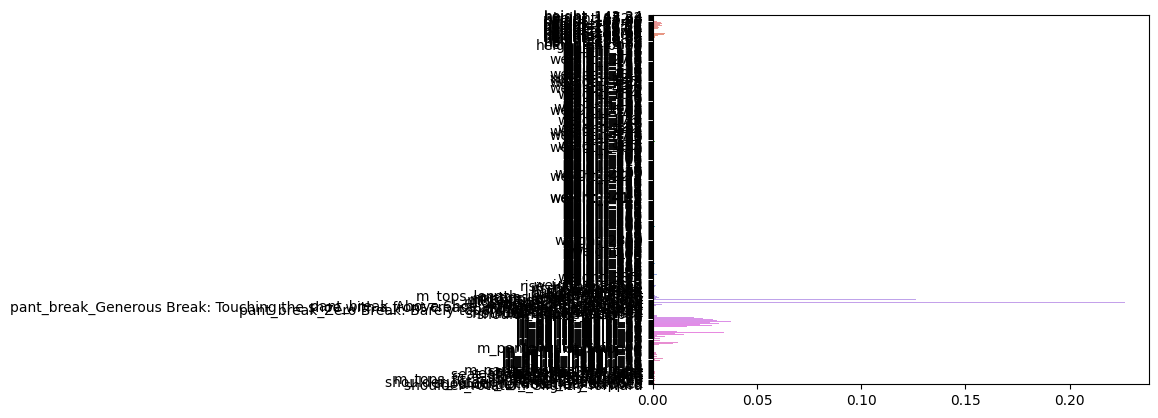

In [168]:
import seaborn as sns
sns.barplot(x=rf_regressor.feature_importances_, y =  rf_regressor.feature_names_in_) #哎呀我去，feature太多了, 323个

In [170]:
zip(rf_regressor.feature_names_in_,rf_regressor.feature_importances_)

In [182]:
pd.Series(rf_regressor.feature_importances_,rf_regressor.feature_names_in_).nlargest(50)

midsection_Significant                                      0.226615
midsection_Medium belly                                     0.126339
m_pants_waist_38                                            0.048612
m_pants_waist_40                                            0.041654
m_pants_waist_32                                            0.037440
m_pants_waist_42                                            0.033956
m_pants_waist_34                                            0.031690
m_pants_waist_31                                            0.030924
m_pants_waist_30                                            0.029022
m_pants_waist_36                                            0.028262
m_pants_waist_33                                            0.027683
m_pants_waist_29                                            0.023917
m_pants_waist_39                                            0.023110
m_pants_waist_35                                            0.022477
m_pants_waist_28                  

In [162]:
# split data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# jackets
xj = jset_f.drop(['Neck', 'Chest', 'Stomach', 'Seat', 'Bicep', 'Shoulder',
       'Front Shoulder', 'Nape', 'Back Length', 'Front Waist Length', 'Sleeve'],axis=1)
yj = jset_f[['Neck', 'Chest', 'Stomach', 'Seat', 'Bicep', 'Shoulder',
       'Front Shoulder', 'Nape', 'Back Length', 'Front Waist Length', 'Sleeve']]

xp = pset_f.drop(['Pants Waist', 'Pants Seat', 'Thigh', 'U-Rise', 'Front Waist Height',
       'Back Waist Height', 'Knee', 'Cuff', 'Outseam'], axis=1)
yp = pset_f[['Pants Waist', 'Pants Seat', 'Thigh', 'U-Rise', 'Front Waist Height',
       'Back Waist Height', 'Knee', 'Cuff', 'Outseam']]
# as is
X = pd.get_dummies(xj,drop_first=False)
xp = pd.get_dummies(xp, drop_first = False)

# # height , weight as numeric
# X=pd.get_dummies(xj,drop_first=False)
# col=X.columns
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# X = pd.DataFrame(X, columns=col)

xj_train, xj_test, yj_train, yj_test = train_test_split(X, yj, test_size= 0.25, random_state=42)

xp_train, xp_test, yp_train, yp_test = train_test_split(xp, yp, test_size = 0.25, random_state = 42)

### Built a baseline model

In [163]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

# model architecture

model = Sequential([
                    Dense(512, activation = 'relu',
                          kernel_regularizer = regularizers.l2(0.05)
                          ), # FC Layers
                    # Dropout(0.5),
                    Dense(512, activation = 'relu',
                          kernel_regularizer = regularizers.l2(0.05)
                          ), # FC Layers
                    Dense(11, activation='linear')
])

model.compile(tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = 'mse',
              metrics = [tf.keras.metrics.MeanAbsolutePercentageError()])


pnt_mod = Sequential([
                    Dense(512, activation = 'relu',
                          kernel_regularizer = regularizers.l2(0.05)
                          ), # FC Layers
                    # Dropout(0.5),
                    Dense(512, activation = 'relu',
                          kernel_regularizer = regularizers.l2(0.05)
                          ), # FC Layers
                    Dense(9, activation='linear')
])

pnt_mod.compile(tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = 'mse',
              metrics = [tf.keras.metrics.MeanAbsoluteError()])

In [ ]:
# fit the model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_percentage_error', patience=25)

checkpoint_best_path = 'model_checkpoints_best/checkpoint_CNN'
checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path,
                             save_freq='epoch',
                             save_weights_only=False,
                             monitor='val_mean_absolute_percentage_error',
                             save_best_only=True,
                             verbose=1)
history = model.fit(xj_train,yj_train, epochs=1000, validation_data= [xj_test,yj_test],  verbose = 1, callbacks = [early_stopping, checkpoint_best])

Epoch 1/1000
220/220 [==============================] - ETA: 0s - loss: 555.8763 - mean_absolute_percentage_error: 15.5648
Epoch 1: val_mean_absolute_percentage_error improved from inf to 2.46223, saving model to model_checkpoints_best/checkpoint_CNN


220/220 [==============================] - 4s 15ms/step - loss: 555.8763 - mean_absolute_percentage_error: 15.5648 - val_loss: 35.9507 - val_mean_absolute_percentage_error: 2.4622
Epoch 2/1000
218/220 [============================>.] - ETA: 0s - loss: 30.9884 - mean_absolute_percentage_error: 2.2127
Epoch 2: val_mean_absolute_percentage_error improved from 2.46223 to 2.11775, saving model to model_checkpoints_best/checkpoint_CNN


220/220 [==============================] - 5s 21ms/step - loss: 30.9508 - mean_absolute_percentage_error: 2.2106 - val_loss: 27.5497 - val_mean_absolute_percentage_error: 2.1177
Epoch 3/1000
219/220 [============================>.] - ETA: 0s - loss: 24.5569 - mean_absolute_percentage_error: 2.0151
Epoch 3: val_mean_absolute_percentage_error improved from 2.11775 to 1.91782, saving model to model_checkpoints_best/checkpoint_CNN


220/220 [==============================] - 3s 14ms/step - loss: 24.5431 - mean_absolute_percentage_error: 2.0149 - val_loss: 22.2417 - val_mean_absolute_percentage_error: 1.9178
Epoch 4/1000
216/220 [============================>.] - ETA: 0s - loss: 20.2673 - mean_absolute_percentage_error: 1.9377
Epoch 4: val_mean_absolute_percentage_error did not improve from 1.91782
220/220 [==============================] - 2s 10ms/step - loss: 20.2420 - mean_absolute_percentage_error: 1.9363 - val_loss: 18.7525 - val_mean_absolute_percentage_error: 1.9336
Epoch 5/1000
217/220 [============================>.] - ETA: 0s - loss: 17.1715 - mean_absolute_percentage_error: 1.8851
Epoch 5: val_mean_absolute_percentage_error improved from 1.91782 to 1.82614, saving model to model_checkpoints_best/checkpoint_CNN


220/220 [==============================] - 3s 14ms/step - loss: 17.1391 - mean_absolute_percentage_error: 1.8835 - val_loss: 15.8688 - val_mean_absolute_percentage_error: 1.8261
Epoch 6/1000
219/220 [============================>.] - ETA: 0s - loss: 14.8921 - mean_absolute_percentage_error: 1.8531
Epoch 6: val_mean_absolute_percentage_error improved from 1.82614 to 1.82240, saving model to model_checkpoints_best/checkpoint_CNN


220/220 [==============================] - 4s 19ms/step - loss: 14.8820 - mean_absolute_percentage_error: 1.8517 - val_loss: 14.1124 - val_mean_absolute_percentage_error: 1.8224
Epoch 7/1000
219/220 [============================>.] - ETA: 0s - loss: 13.3432 - mean_absolute_percentage_error: 1.8756
Epoch 7: val_mean_absolute_percentage_error improved from 1.82240 to 1.75078, saving model to model_checkpoints_best/checkpoint_CNN


220/220 [==============================] - 4s 16ms/step - loss: 13.3527 - mean_absolute_percentage_error: 1.8773 - val_loss: 12.4713 - val_mean_absolute_percentage_error: 1.7508
Epoch 8/1000
217/220 [============================>.] - ETA: 0s - loss: 12.0594 - mean_absolute_percentage_error: 1.8109
Epoch 8: val_mean_absolute_percentage_error improved from 1.75078 to 1.74601, saving model to model_checkpoints_best/checkpoint_CNN


220/220 [==============================] - 3s 14ms/step - loss: 12.0446 - mean_absolute_percentage_error: 1.8105 - val_loss: 11.4778 - val_mean_absolute_percentage_error: 1.7460
Epoch 9/1000
219/220 [============================>.] - ETA: 0s - loss: 11.3668 - mean_absolute_percentage_error: 1.9036
Epoch 9: val_mean_absolute_percentage_error did not improve from 1.74601
220/220 [==============================] - 2s 10ms/step - loss: 11.3688 - mean_absolute_percentage_error: 1.9041 - val_loss: 10.8129 - val_mean_absolute_percentage_error: 1.7526
Epoch 10/1000
220/220 [==============================] - ETA: 0s - loss: 10.5694 - mean_absolute_percentage_error: 1.8133
Epoch 10: val_mean_absolute_percentage_error did not improve from 1.74601
220/220 [==============================] - 4s 17ms/step - loss: 10.5694 - mean_absolute_percentage_error: 1.8133 - val_loss: 10.3180 - val_mean_absolute_percentage_error: 1.7852
Epoch 11/1000
218/220 [============================>.] - ETA: 0s - loss: 10.

220/220 [==============================] - 3s 15ms/step - loss: 8.4975 - mean_absolute_percentage_error: 1.9278 - val_loss: 7.8867 - val_mean_absolute_percentage_error: 1.7070
Epoch 21/1000
218/220 [============================>.] - ETA: 0s - loss: 8.1391 - mean_absolute_percentage_error: 1.8515
Epoch 21: val_mean_absolute_percentage_error did not improve from 1.70701
220/220 [==============================] - 3s 15ms/step - loss: 8.1343 - mean_absolute_percentage_error: 1.8513 - val_loss: 8.2137 - val_mean_absolute_percentage_error: 1.8208
Epoch 22/1000
219/220 [============================>.] - ETA: 0s - loss: 8.0640 - mean_absolute_percentage_error: 1.8711
Epoch 22: val_mean_absolute_percentage_error improved from 1.70701 to 1.69098, saving model to model_checkpoints_best/checkpoint_CNN


220/220 [==============================] - 3s 15ms/step - loss: 8.0689 - mean_absolute_percentage_error: 1.8714 - val_loss: 7.6169 - val_mean_absolute_percentage_error: 1.6910
Epoch 23/1000
220/220 [==============================] - ETA: 0s - loss: 7.9945 - mean_absolute_percentage_error: 1.8841
Epoch 23: val_mean_absolute_percentage_error did not improve from 1.69098
220/220 [==============================] - 2s 11ms/step - loss: 7.9945 - mean_absolute_percentage_error: 1.8841 - val_loss: 7.8952 - val_mean_absolute_percentage_error: 1.8368
Epoch 24/1000
220/220 [==============================] - ETA: 0s - loss: 8.4332 - mean_absolute_percentage_error: 2.0541
Epoch 24: val_mean_absolute_percentage_error did not improve from 1.69098
220/220 [==============================] - 2s 10ms/step - loss: 8.4332 - mean_absolute_percentage_error: 2.0541 - val_loss: 9.4710 - val_mean_absolute_percentage_error: 2.4051
Epoch 25/1000
219/220 [============================>.] - ETA: 0s - loss: 8.0355 - 

220/220 [==============================] - 4s 18ms/step - loss: 7.5662 - mean_absolute_percentage_error: 1.8816 - val_loss: 7.0204 - val_mean_absolute_percentage_error: 1.6706
Epoch 29/1000
218/220 [============================>.] - ETA: 0s - loss: 7.3573 - mean_absolute_percentage_error: 1.8152
Epoch 29: val_mean_absolute_percentage_error did not improve from 1.67061
220/220 [==============================] - 2s 10ms/step - loss: 7.3500 - mean_absolute_percentage_error: 1.8146 - val_loss: 7.9561 - val_mean_absolute_percentage_error: 2.0206
Epoch 30/1000
215/220 [============================>.] - ETA: 0s - loss: 7.3088 - mean_absolute_percentage_error: 1.8125
Epoch 30: val_mean_absolute_percentage_error did not improve from 1.67061
220/220 [==============================] - 2s 11ms/step - loss: 7.2823 - mean_absolute_percentage_error: 1.8078 - val_loss: 7.0270 - val_mean_absolute_percentage_error: 1.7026
Epoch 31/1000
218/220 [============================>.] - ETA: 0s - loss: 7.6272 - 

220/220 [==============================] - 3s 15ms/step - loss: 7.0562 - mean_absolute_percentage_error: 1.8334 - val_loss: 6.8626 - val_mean_absolute_percentage_error: 1.6664
Epoch 35/1000
218/220 [============================>.] - ETA: 0s - loss: 6.9986 - mean_absolute_percentage_error: 1.8091
Epoch 35: val_mean_absolute_percentage_error did not improve from 1.66637
220/220 [==============================] - 2s 11ms/step - loss: 7.0092 - mean_absolute_percentage_error: 1.8128 - val_loss: 10.2314 - val_mean_absolute_percentage_error: 2.9547
Epoch 36/1000
218/220 [============================>.] - ETA: 0s - loss: 7.2797 - mean_absolute_percentage_error: 1.9304
Epoch 36: val_mean_absolute_percentage_error did not improve from 1.66637
220/220 [==============================] - 3s 16ms/step - loss: 7.2640 - mean_absolute_percentage_error: 1.9281 - val_loss: 6.7159 - val_mean_absolute_percentage_error: 1.6789
Epoch 37/1000
218/220 [============================>.] - ETA: 0s - loss: 6.6467 -

220/220 [==============================] - 4s 19ms/step - loss: 6.5046 - mean_absolute_percentage_error: 1.7420 - val_loss: 6.2036 - val_mean_absolute_percentage_error: 1.5941
Epoch 43/1000
220/220 [==============================] - ETA: 0s - loss: 6.5871 - mean_absolute_percentage_error: 1.8068
Epoch 43: val_mean_absolute_percentage_error did not improve from 1.59412
220/220 [==============================] - 2s 10ms/step - loss: 6.5871 - mean_absolute_percentage_error: 1.8068 - val_loss: 7.2028 - val_mean_absolute_percentage_error: 2.0159
Epoch 44/1000
215/220 [============================>.] - ETA: 0s - loss: 6.6789 - mean_absolute_percentage_error: 1.8425
Epoch 44: val_mean_absolute_percentage_error did not improve from 1.59412
220/220 [==============================] - 2s 10ms/step - loss: 6.6627 - mean_absolute_percentage_error: 1.8405 - val_loss: 6.2062 - val_mean_absolute_percentage_error: 1.6779
Epoch 45/1000
217/220 [============================>.] - ETA: 0s - loss: 6.3962 - 

220/220 [==============================] - 3s 14ms/step - loss: 5.9515 - mean_absolute_percentage_error: 1.6411 - val_loss: 5.9031 - val_mean_absolute_percentage_error: 1.5705
Epoch 52/1000
219/220 [============================>.] - ETA: 0s - loss: 6.0623 - mean_absolute_percentage_error: 1.7152
Epoch 52: val_mean_absolute_percentage_error improved from 1.57055 to 1.55483, saving model to model_checkpoints_best/checkpoint_CNN


220/220 [==============================] - 4s 18ms/step - loss: 6.0645 - mean_absolute_percentage_error: 1.7157 - val_loss: 5.9047 - val_mean_absolute_percentage_error: 1.5548
Epoch 53/1000
218/220 [============================>.] - ETA: 0s - loss: 6.0965 - mean_absolute_percentage_error: 1.7406
Epoch 53: val_mean_absolute_percentage_error did not improve from 1.55483
220/220 [==============================] - 3s 14ms/step - loss: 6.1092 - mean_absolute_percentage_error: 1.7390 - val_loss: 5.8972 - val_mean_absolute_percentage_error: 1.5936
Epoch 54/1000
219/220 [============================>.] - ETA: 0s - loss: 5.9810 - mean_absolute_percentage_error: 1.7032
Epoch 54: val_mean_absolute_percentage_error did not improve from 1.55483
220/220 [==============================] - 2s 10ms/step - loss: 5.9761 - mean_absolute_percentage_error: 1.7029 - val_loss: 5.8599 - val_mean_absolute_percentage_error: 1.6067
Epoch 55/1000
218/220 [============================>.] - ETA: 0s - loss: 5.9277 - 

220/220 [==============================] - 3s 14ms/step - loss: 5.6632 - mean_absolute_percentage_error: 1.6883 - val_loss: 5.4300 - val_mean_absolute_percentage_error: 1.5229
Epoch 67/1000
220/220 [==============================] - ETA: 0s - loss: 5.5393 - mean_absolute_percentage_error: 1.6429
Epoch 67: val_mean_absolute_percentage_error did not improve from 1.52287
220/220 [==============================] - 2s 10ms/step - loss: 5.5393 - mean_absolute_percentage_error: 1.6429 - val_loss: 5.4558 - val_mean_absolute_percentage_error: 1.5580
Epoch 68/1000
219/220 [============================>.] - ETA: 0s - loss: 5.4639 - mean_absolute_percentage_error: 1.6188
Epoch 68: val_mean_absolute_percentage_error did not improve from 1.52287
220/220 [==============================] - 2s 11ms/step - loss: 5.4653 - mean_absolute_percentage_error: 1.6195 - val_loss: 5.3616 - val_mean_absolute_percentage_error: 1.5639
Epoch 69/1000
219/220 [============================>.] - ETA: 0s - loss: 5.4564 - 

220/220 [==============================] - 3s 14ms/step - loss: 5.3970 - mean_absolute_percentage_error: 1.6090 - val_loss: 5.3406 - val_mean_absolute_percentage_error: 1.4790
Epoch 73/1000
218/220 [============================>.] - ETA: 0s - loss: 5.3404 - mean_absolute_percentage_error: 1.5936
Epoch 73: val_mean_absolute_percentage_error did not improve from 1.47900
220/220 [==============================] - 2s 10ms/step - loss: 5.3335 - mean_absolute_percentage_error: 1.5924 - val_loss: 5.4620 - val_mean_absolute_percentage_error: 1.6319
Epoch 74/1000
219/220 [============================>.] - ETA: 0s - loss: 5.4137 - mean_absolute_percentage_error: 1.6573
Epoch 74: val_mean_absolute_percentage_error did not improve from 1.47900
220/220 [==============================] - 3s 14ms/step - loss: 5.4120 - mean_absolute_percentage_error: 1.6571 - val_loss: 5.6701 - val_mean_absolute_percentage_error: 1.8065
Epoch 75/1000
218/220 [============================>.] - ETA: 0s - loss: 5.3994 - 

220/220 [==============================] - 4s 18ms/step - loss: 5.3923 - mean_absolute_percentage_error: 1.6311 - val_loss: 5.2172 - val_mean_absolute_percentage_error: 1.4720
Epoch 76/1000
217/220 [============================>.] - ETA: 0s - loss: 5.2381 - mean_absolute_percentage_error: 1.5711
Epoch 76: val_mean_absolute_percentage_error did not improve from 1.47200
220/220 [==============================] - 2s 10ms/step - loss: 5.2362 - mean_absolute_percentage_error: 1.5711 - val_loss: 6.2562 - val_mean_absolute_percentage_error: 2.0245
Epoch 77/1000
216/220 [============================>.] - ETA: 0s - loss: 5.3092 - mean_absolute_percentage_error: 1.6297
Epoch 77: val_mean_absolute_percentage_error did not improve from 1.47200
220/220 [==============================] - 2s 11ms/step - loss: 5.2984 - mean_absolute_percentage_error: 1.6249 - val_loss: 5.6926 - val_mean_absolute_percentage_error: 1.6543
Epoch 78/1000
220/220 [==============================] - ETA: 0s - loss: 5.3327 - 

220/220 [==============================] - 4s 17ms/step - loss: 5.1695 - mean_absolute_percentage_error: 1.5756 - val_loss: 5.0759 - val_mean_absolute_percentage_error: 1.4591
Epoch 80/1000
218/220 [============================>.] - ETA: 0s - loss: 5.1599 - mean_absolute_percentage_error: 1.5633
Epoch 80: val_mean_absolute_percentage_error did not improve from 1.45912
220/220 [==============================] - 3s 14ms/step - loss: 5.1518 - mean_absolute_percentage_error: 1.5615 - val_loss: 5.1432 - val_mean_absolute_percentage_error: 1.4838
Epoch 81/1000
216/220 [============================>.] - ETA: 0s - loss: 5.2075 - mean_absolute_percentage_error: 1.6173
Epoch 81: val_mean_absolute_percentage_error did not improve from 1.45912
220/220 [==============================] - 2s 11ms/step - loss: 5.2142 - mean_absolute_percentage_error: 1.6162 - val_loss: 5.2973 - val_mean_absolute_percentage_error: 1.7023
Epoch 82/1000
216/220 [============================>.] - ETA: 0s - loss: 5.0886 - 

220/220 [==============================] - 4s 18ms/step - loss: 4.9258 - mean_absolute_percentage_error: 1.5740 - val_loss: 4.8133 - val_mean_absolute_percentage_error: 1.4460
Epoch 97/1000
219/220 [============================>.] - ETA: 0s - loss: 4.7297 - mean_absolute_percentage_error: 1.4648
Epoch 97: val_mean_absolute_percentage_error did not improve from 1.44598
220/220 [==============================] - 3s 14ms/step - loss: 4.7287 - mean_absolute_percentage_error: 1.4648 - val_loss: 4.8979 - val_mean_absolute_percentage_error: 1.5061
Epoch 98/1000
220/220 [==============================] - ETA: 0s - loss: 4.7611 - mean_absolute_percentage_error: 1.5009
Epoch 98: val_mean_absolute_percentage_error did not improve from 1.44598
220/220 [==============================] - 2s 11ms/step - loss: 4.7611 - mean_absolute_percentage_error: 1.5009 - val_loss: 4.9595 - val_mean_absolute_percentage_error: 1.4709
Epoch 99/1000
219/220 [============================>.] - ETA: 0s - loss: 4.7489 - 

220/220 [==============================] - 4s 16ms/step - loss: 4.6676 - mean_absolute_percentage_error: 1.4704 - val_loss: 4.7087 - val_mean_absolute_percentage_error: 1.4211
Epoch 102/1000
217/220 [============================>.] - ETA: 0s - loss: 4.7100 - mean_absolute_percentage_error: 1.4990
Epoch 102: val_mean_absolute_percentage_error did not improve from 1.42114
220/220 [==============================] - 3s 16ms/step - loss: 4.7179 - mean_absolute_percentage_error: 1.5001 - val_loss: 4.7808 - val_mean_absolute_percentage_error: 1.4480
Epoch 103/1000
217/220 [============================>.] - ETA: 0s - loss: 4.7871 - mean_absolute_percentage_error: 1.5438
Epoch 103: val_mean_absolute_percentage_error did not improve from 1.42114
220/220 [==============================] - 2s 11ms/step - loss: 4.7804 - mean_absolute_percentage_error: 1.5435 - val_loss: 4.7178 - val_mean_absolute_percentage_error: 1.4622
Epoch 104/1000
216/220 [============================>.] - ETA: 0s - loss: 4.84

220/220 [==============================] - 4s 19ms/step - loss: 4.5834 - mean_absolute_percentage_error: 1.4636 - val_loss: 4.6937 - val_mean_absolute_percentage_error: 1.4136
Epoch 109/1000
220/220 [==============================] - ETA: 0s - loss: 4.6072 - mean_absolute_percentage_error: 1.4739
Epoch 109: val_mean_absolute_percentage_error improved from 1.41359 to 1.39420, saving model to model_checkpoints_best/checkpoint_CNN


220/220 [==============================] - 3s 14ms/step - loss: 4.6072 - mean_absolute_percentage_error: 1.4739 - val_loss: 4.6379 - val_mean_absolute_percentage_error: 1.3942
Epoch 110/1000
219/220 [============================>.] - ETA: 0s - loss: 4.5458 - mean_absolute_percentage_error: 1.4578
Epoch 110: val_mean_absolute_percentage_error did not improve from 1.39420
220/220 [==============================] - 2s 11ms/step - loss: 4.5428 - mean_absolute_percentage_error: 1.4572 - val_loss: 4.6191 - val_mean_absolute_percentage_error: 1.4069
Epoch 111/1000
218/220 [============================>.] - ETA: 0s - loss: 4.5521 - mean_absolute_percentage_error: 1.4719
Epoch 111: val_mean_absolute_percentage_error did not improve from 1.39420
220/220 [==============================] - 2s 10ms/step - loss: 4.5746 - mean_absolute_percentage_error: 1.4746 - val_loss: 4.8708 - val_mean_absolute_percentage_error: 1.6777
Epoch 112/1000
219/220 [============================>.] - ETA: 0s - loss: 4.57

220/220 [==============================] - 3s 14ms/step - loss: 4.3880 - mean_absolute_percentage_error: 1.4344 - val_loss: 4.4094 - val_mean_absolute_percentage_error: 1.3687
Epoch 128/1000
220/220 [==============================] - ETA: 0s - loss: 4.3833 - mean_absolute_percentage_error: 1.4429
Epoch 128: val_mean_absolute_percentage_error did not improve from 1.36874
220/220 [==============================] - 3s 16ms/step - loss: 4.3833 - mean_absolute_percentage_error: 1.4429 - val_loss: 4.4899 - val_mean_absolute_percentage_error: 1.4286
Epoch 129/1000
217/220 [============================>.] - ETA: 0s - loss: 4.3507 - mean_absolute_percentage_error: 1.4258
Epoch 129: val_mean_absolute_percentage_error did not improve from 1.36874
220/220 [==============================] - 3s 13ms/step - loss: 4.3587 - mean_absolute_percentage_error: 1.4252 - val_loss: 4.4567 - val_mean_absolute_percentage_error: 1.3900
Epoch 130/1000
217/220 [============================>.] - ETA: 0s - loss: 4.41

220/220 [==============================] - 3s 14ms/step - loss: 4.4079 - mean_absolute_percentage_error: 1.4594 - val_loss: 4.4757 - val_mean_absolute_percentage_error: 1.3618
Epoch 131/1000
220/220 [==============================] - ETA: 0s - loss: 4.3581 - mean_absolute_percentage_error: 1.4441
Epoch 131: val_mean_absolute_percentage_error did not improve from 1.36176
220/220 [==============================] - 2s 10ms/step - loss: 4.3581 - mean_absolute_percentage_error: 1.4441 - val_loss: 4.3979 - val_mean_absolute_percentage_error: 1.3826
Epoch 132/1000
217/220 [============================>.] - ETA: 0s - loss: 4.2739 - mean_absolute_percentage_error: 1.4087
Epoch 132: val_mean_absolute_percentage_error did not improve from 1.36176
220/220 [==============================] - 2s 11ms/step - loss: 4.2948 - mean_absolute_percentage_error: 1.4093 - val_loss: 4.5056 - val_mean_absolute_percentage_error: 1.4710
Epoch 133/1000
218/220 [============================>.] - ETA: 0s - loss: 4.26

220/220 [==============================] - 4s 16ms/step - loss: 4.2402 - mean_absolute_percentage_error: 1.4118 - val_loss: 4.3582 - val_mean_absolute_percentage_error: 1.3559
Epoch 139/1000
218/220 [============================>.] - ETA: 0s - loss: 4.2718 - mean_absolute_percentage_error: 1.4182
Epoch 139: val_mean_absolute_percentage_error did not improve from 1.35592
220/220 [==============================] - 3s 15ms/step - loss: 4.2596 - mean_absolute_percentage_error: 1.4170 - val_loss: 4.4537 - val_mean_absolute_percentage_error: 1.4242
Epoch 140/1000
216/220 [============================>.] - ETA: 0s - loss: 4.2782 - mean_absolute_percentage_error: 1.4330
Epoch 140: val_mean_absolute_percentage_error did not improve from 1.35592
220/220 [==============================] - 2s 11ms/step - loss: 4.2734 - mean_absolute_percentage_error: 1.4321 - val_loss: 4.3566 - val_mean_absolute_percentage_error: 1.3746
Epoch 141/1000
215/220 [============================>.] - ETA: 0s - loss: 4.20

220/220 [==============================] - 3s 15ms/step - loss: 4.0462 - mean_absolute_percentage_error: 1.3709 - val_loss: 4.2414 - val_mean_absolute_percentage_error: 1.3548
Epoch 163/1000
216/220 [============================>.] - ETA: 0s - loss: 4.0560 - mean_absolute_percentage_error: 1.3817
Epoch 163: val_mean_absolute_percentage_error did not improve from 1.35478
220/220 [==============================] - 2s 11ms/step - loss: 4.0525 - mean_absolute_percentage_error: 1.3799 - val_loss: 4.1802 - val_mean_absolute_percentage_error: 1.3559
Epoch 164/1000
217/220 [============================>.] - ETA: 0s - loss: 3.9955 - mean_absolute_percentage_error: 1.3554
Epoch 164: val_mean_absolute_percentage_error did not improve from 1.35478
220/220 [==============================] - 2s 11ms/step - loss: 4.0065 - mean_absolute_percentage_error: 1.3565 - val_loss: 4.2211 - val_mean_absolute_percentage_error: 1.4630
Epoch 165/1000
219/220 [============================>.] - ETA: 0s - loss: 4.04

220/220 [==============================] - 4s 18ms/step - loss: 3.9995 - mean_absolute_percentage_error: 1.3551 - val_loss: 4.2238 - val_mean_absolute_percentage_error: 1.3539
Epoch 167/1000
217/220 [============================>.] - ETA: 0s - loss: 4.0202 - mean_absolute_percentage_error: 1.3645
Epoch 167: val_mean_absolute_percentage_error did not improve from 1.35387
220/220 [==============================] - 3s 11ms/step - loss: 4.0228 - mean_absolute_percentage_error: 1.3647 - val_loss: 4.3256 - val_mean_absolute_percentage_error: 1.4743
Epoch 168/1000
220/220 [==============================] - ETA: 0s - loss: 3.9774 - mean_absolute_percentage_error: 1.3601
Epoch 168: val_mean_absolute_percentage_error did not improve from 1.35387
220/220 [==============================] - 2s 11ms/step - loss: 3.9774 - mean_absolute_percentage_error: 1.3601 - val_loss: 4.1888 - val_mean_absolute_percentage_error: 1.3651
Epoch 169/1000
219/220 [============================>.] - ETA: 0s - loss: 3.98

220/220 [==============================] - 4s 18ms/step - loss: 3.9628 - mean_absolute_percentage_error: 1.3538 - val_loss: 4.1511 - val_mean_absolute_percentage_error: 1.3490
Epoch 172/1000
216/220 [============================>.] - ETA: 0s - loss: 3.9459 - mean_absolute_percentage_error: 1.3536
Epoch 172: val_mean_absolute_percentage_error did not improve from 1.34901
220/220 [==============================] - 2s 11ms/step - loss: 3.9562 - mean_absolute_percentage_error: 1.3529 - val_loss: 4.4807 - val_mean_absolute_percentage_error: 1.4894
Epoch 173/1000
220/220 [==============================] - ETA: 0s - loss: 3.9953 - mean_absolute_percentage_error: 1.3754
Epoch 173: val_mean_absolute_percentage_error did not improve from 1.34901
220/220 [==============================] - 2s 11ms/step - loss: 3.9953 - mean_absolute_percentage_error: 1.3754 - val_loss: 4.1647 - val_mean_absolute_percentage_error: 1.3614
Epoch 174/1000
218/220 [============================>.] - ETA: 0s - loss: 3.94

220/220 [==============================] - 3s 15ms/step - loss: 3.9340 - mean_absolute_percentage_error: 1.3575 - val_loss: 4.1182 - val_mean_absolute_percentage_error: 1.3442
Epoch 178/1000
220/220 [==============================] - ETA: 0s - loss: 3.9425 - mean_absolute_percentage_error: 1.3600
Epoch 178: val_mean_absolute_percentage_error did not improve from 1.34420
220/220 [==============================] - 2s 11ms/step - loss: 3.9425 - mean_absolute_percentage_error: 1.3600 - val_loss: 4.2014 - val_mean_absolute_percentage_error: 1.3616
Epoch 179/1000
218/220 [============================>.] - ETA: 0s - loss: 3.9507 - mean_absolute_percentage_error: 1.3729
Epoch 179: val_mean_absolute_percentage_error did not improve from 1.34420
220/220 [==============================] - 2s 11ms/step - loss: 3.9500 - mean_absolute_percentage_error: 1.3735 - val_loss: 4.2010 - val_mean_absolute_percentage_error: 1.3702
Epoch 180/1000
218/220 [============================>.] - ETA: 0s - loss: 3.92

220/220 [==============================] - 4s 20ms/step - loss: 3.9104 - mean_absolute_percentage_error: 1.3475 - val_loss: 4.1144 - val_mean_absolute_percentage_error: 1.3278
Epoch 182/1000
219/220 [============================>.] - ETA: 0s - loss: 3.9046 - mean_absolute_percentage_error: 1.3563
Epoch 182: val_mean_absolute_percentage_error did not improve from 1.32778
220/220 [==============================] - 2s 11ms/step - loss: 3.9044 - mean_absolute_percentage_error: 1.3564 - val_loss: 4.2051 - val_mean_absolute_percentage_error: 1.3827
Epoch 183/1000
218/220 [============================>.] - ETA: 0s - loss: 3.8950 - mean_absolute_percentage_error: 1.3419
Epoch 183: val_mean_absolute_percentage_error improved from 1.32778 to 1.32182, saving model to model_checkpoints_best/checkpoint_CNN


220/220 [==============================] - 3s 14ms/step - loss: 3.8981 - mean_absolute_percentage_error: 1.3428 - val_loss: 4.0716 - val_mean_absolute_percentage_error: 1.3218
Epoch 184/1000
220/220 [==============================] - ETA: 0s - loss: 3.8934 - mean_absolute_percentage_error: 1.3433
Epoch 184: val_mean_absolute_percentage_error did not improve from 1.32182
220/220 [==============================] - 2s 11ms/step - loss: 3.8934 - mean_absolute_percentage_error: 1.3433 - val_loss: 4.5293 - val_mean_absolute_percentage_error: 1.6172
Epoch 185/1000
218/220 [============================>.] - ETA: 0s - loss: 3.8983 - mean_absolute_percentage_error: 1.3604
Epoch 185: val_mean_absolute_percentage_error did not improve from 1.32182
220/220 [==============================] - 3s 13ms/step - loss: 3.9109 - mean_absolute_percentage_error: 1.3621 - val_loss: 4.1476 - val_mean_absolute_percentage_error: 1.3822
Epoch 186/1000
218/220 [============================>.] - ETA: 0s - loss: 3.89

Baseline model has an overall $MAE = 1.26$

In [164]:
# fit the model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=25)

checkpoint_best_path = 'model_checkpoints_best/checkpoint_CNN'
checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path,
                             save_freq='epoch',
                             save_weights_only=False,
                             monitor='val_mean_absolute_error',
                             save_best_only=True,
                             verbose=1)
history = pnt_mod.fit(xp_train,yp_train, epochs=1000, validation_data= [xp_test,yp_test],  verbose = 1, callbacks = [early_stopping, checkpoint_best])

Epoch 1/1000
155/158 [============================>.] - ETA: 0s - loss: 719.8395 - mean_absolute_error: 12.6755
Epoch 1: val_mean_absolute_error improved from inf to 2.34901, saving model to model_checkpoints_best/checkpoint_CNN


158/158 [==============================] - 6s 24ms/step - loss: 711.1655 - mean_absolute_error: 12.5413 - val_loss: 47.2614 - val_mean_absolute_error: 2.3490
Epoch 2/1000
152/158 [===========================>..] - ETA: 0s - loss: 40.0543 - mean_absolute_error: 2.0038
Epoch 2: val_mean_absolute_error improved from 2.34901 to 1.80674, saving model to model_checkpoints_best/checkpoint_CNN


158/158 [==============================] - 2s 15ms/step - loss: 40.0763 - mean_absolute_error: 2.0032 - val_loss: 35.6914 - val_mean_absolute_error: 1.8067
Epoch 3/1000
157/158 [============================>.] - ETA: 0s - loss: 31.5072 - mean_absolute_error: 1.6148
Epoch 3: val_mean_absolute_error improved from 1.80674 to 1.69951, saving model to model_checkpoints_best/checkpoint_CNN


158/158 [==============================] - 3s 21ms/step - loss: 31.5103 - mean_absolute_error: 1.6152 - val_loss: 30.3195 - val_mean_absolute_error: 1.6995
Epoch 4/1000
153/158 [============================>.] - ETA: 0s - loss: 26.8261 - mean_absolute_error: 1.5209
Epoch 4: val_mean_absolute_error improved from 1.69951 to 1.49672, saving model to model_checkpoints_best/checkpoint_CNN


158/158 [==============================] - 3s 18ms/step - loss: 26.7655 - mean_absolute_error: 1.5186 - val_loss: 25.4067 - val_mean_absolute_error: 1.4967
Epoch 5/1000
157/158 [============================>.] - ETA: 0s - loss: 22.8807 - mean_absolute_error: 1.4000
Epoch 5: val_mean_absolute_error improved from 1.49672 to 1.36461, saving model to model_checkpoints_best/checkpoint_CNN


158/158 [==============================] - 2s 15ms/step - loss: 22.8809 - mean_absolute_error: 1.4002 - val_loss: 22.0134 - val_mean_absolute_error: 1.3646
Epoch 6/1000
155/158 [============================>.] - ETA: 0s - loss: 20.0594 - mean_absolute_error: 1.3527
Epoch 6: val_mean_absolute_error improved from 1.36461 to 1.29008, saving model to model_checkpoints_best/checkpoint_CNN


158/158 [==============================] - 2s 15ms/step - loss: 20.0928 - mean_absolute_error: 1.3544 - val_loss: 19.5473 - val_mean_absolute_error: 1.2901
Epoch 7/1000
158/158 [==============================] - ETA: 0s - loss: 17.7844 - mean_absolute_error: 1.2741
Epoch 7: val_mean_absolute_error did not improve from 1.29008
158/158 [==============================] - 2s 10ms/step - loss: 17.7844 - mean_absolute_error: 1.2741 - val_loss: 17.9742 - val_mean_absolute_error: 1.4020
Epoch 8/1000
156/158 [============================>.] - ETA: 0s - loss: 16.1085 - mean_absolute_error: 1.2605
Epoch 8: val_mean_absolute_error improved from 1.29008 to 1.26592, saving model to model_checkpoints_best/checkpoint_CNN


158/158 [==============================] - 2s 15ms/step - loss: 16.0899 - mean_absolute_error: 1.2590 - val_loss: 16.0023 - val_mean_absolute_error: 1.2659
Epoch 9/1000
155/158 [============================>.] - ETA: 0s - loss: 14.7081 - mean_absolute_error: 1.2285
Epoch 9: val_mean_absolute_error did not improve from 1.26592
158/158 [==============================] - 2s 15ms/step - loss: 14.7016 - mean_absolute_error: 1.2291 - val_loss: 15.6451 - val_mean_absolute_error: 1.4239
Epoch 10/1000
156/158 [============================>.] - ETA: 0s - loss: 13.7392 - mean_absolute_error: 1.2396
Epoch 10: val_mean_absolute_error improved from 1.26592 to 1.25897, saving model to model_checkpoints_best/checkpoint_CNN


158/158 [==============================] - 4s 24ms/step - loss: 13.7349 - mean_absolute_error: 1.2397 - val_loss: 14.1021 - val_mean_absolute_error: 1.2590
Epoch 11/1000
152/158 [===========================>..] - ETA: 0s - loss: 12.8836 - mean_absolute_error: 1.2354
Epoch 11: val_mean_absolute_error did not improve from 1.25897
158/158 [==============================] - 2s 10ms/step - loss: 12.9568 - mean_absolute_error: 1.2375 - val_loss: 14.2346 - val_mean_absolute_error: 1.4725
Epoch 12/1000
154/158 [============================>.] - ETA: 0s - loss: 12.3190 - mean_absolute_error: 1.2370
Epoch 12: val_mean_absolute_error did not improve from 1.25897
158/158 [==============================] - 2s 10ms/step - loss: 12.2932 - mean_absolute_error: 1.2344 - val_loss: 13.5749 - val_mean_absolute_error: 1.4727
Epoch 13/1000
157/158 [============================>.] - ETA: 0s - loss: 11.5897 - mean_absolute_error: 1.1930
Epoch 13: val_mean_absolute_error did not improve from 1.25897
158/158 [=

158/158 [==============================] - 3s 20ms/step - loss: 10.6078 - mean_absolute_error: 1.2324 - val_loss: 10.7756 - val_mean_absolute_error: 1.1432
Epoch 17/1000
156/158 [============================>.] - ETA: 0s - loss: 10.3247 - mean_absolute_error: 1.2184
Epoch 17: val_mean_absolute_error did not improve from 1.14321
158/158 [==============================] - 2s 14ms/step - loss: 10.3248 - mean_absolute_error: 1.2195 - val_loss: 11.1425 - val_mean_absolute_error: 1.3557
Epoch 18/1000
152/158 [===========================>..] - ETA: 0s - loss: 10.2404 - mean_absolute_error: 1.2587
Epoch 18: val_mean_absolute_error did not improve from 1.14321
158/158 [==============================] - 2s 10ms/step - loss: 10.2151 - mean_absolute_error: 1.2583 - val_loss: 10.2032 - val_mean_absolute_error: 1.1624
Epoch 19/1000
157/158 [============================>.] - ETA: 0s - loss: 9.8037 - mean_absolute_error: 1.2174
Epoch 19: val_mean_absolute_error did not improve from 1.14321
158/158 [==

158/158 [==============================] - 2s 16ms/step - loss: 9.8646 - mean_absolute_error: 1.4976 - val_loss: 8.5573 - val_mean_absolute_error: 1.1327
Epoch 32/1000
157/158 [============================>.] - ETA: 0s - loss: 8.0236 - mean_absolute_error: 1.1708
Epoch 32: val_mean_absolute_error did not improve from 1.13267
158/158 [==============================] - 2s 15ms/step - loss: 8.0230 - mean_absolute_error: 1.1707 - val_loss: 9.3451 - val_mean_absolute_error: 1.3502
Epoch 33/1000
156/158 [============================>.] - ETA: 0s - loss: 7.7266 - mean_absolute_error: 1.1316
Epoch 33: val_mean_absolute_error improved from 1.13267 to 1.10192, saving model to model_checkpoints_best/checkpoint_CNN


158/158 [==============================] - 3s 19ms/step - loss: 7.7162 - mean_absolute_error: 1.1305 - val_loss: 8.1844 - val_mean_absolute_error: 1.1019
Epoch 34/1000
154/158 [============================>.] - ETA: 0s - loss: 7.7051 - mean_absolute_error: 1.1475
Epoch 34: val_mean_absolute_error did not improve from 1.10192
158/158 [==============================] - 2s 10ms/step - loss: 7.7230 - mean_absolute_error: 1.1501 - val_loss: 8.6136 - val_mean_absolute_error: 1.1978
Epoch 35/1000
154/158 [============================>.] - ETA: 0s - loss: 7.9117 - mean_absolute_error: 1.2041
Epoch 35: val_mean_absolute_error did not improve from 1.10192
158/158 [==============================] - 2s 10ms/step - loss: 7.9041 - mean_absolute_error: 1.2039 - val_loss: 9.7333 - val_mean_absolute_error: 1.5071
Epoch 36/1000
154/158 [============================>.] - ETA: 0s - loss: 7.7125 - mean_absolute_error: 1.1804
Epoch 36: val_mean_absolute_error did not improve from 1.10192
158/158 [==========

158/158 [==============================] - 2s 15ms/step - loss: 7.4548 - mean_absolute_error: 1.1504 - val_loss: 7.8314 - val_mean_absolute_error: 1.0823
Epoch 39/1000
157/158 [============================>.] - ETA: 0s - loss: 7.3694 - mean_absolute_error: 1.1557
Epoch 39: val_mean_absolute_error did not improve from 1.08226
158/158 [==============================] - 2s 15ms/step - loss: 7.3691 - mean_absolute_error: 1.1557 - val_loss: 7.9765 - val_mean_absolute_error: 1.1816
Epoch 40/1000
156/158 [============================>.] - ETA: 0s - loss: 7.4188 - mean_absolute_error: 1.1781
Epoch 40: val_mean_absolute_error did not improve from 1.08226
158/158 [==============================] - 2s 15ms/step - loss: 7.4378 - mean_absolute_error: 1.1793 - val_loss: 8.0328 - val_mean_absolute_error: 1.2187
Epoch 41/1000
153/158 [============================>.] - ETA: 0s - loss: 7.3450 - mean_absolute_error: 1.1780
Epoch 41: val_mean_absolute_error did not improve from 1.08226
158/158 [==========

158/158 [==============================] - 2s 15ms/step - loss: 6.4756 - mean_absolute_error: 1.1403 - val_loss: 6.9119 - val_mean_absolute_error: 1.0745
Epoch 61/1000
158/158 [==============================] - ETA: 0s - loss: 5.9935 - mean_absolute_error: 1.0490
Epoch 61: val_mean_absolute_error improved from 1.07453 to 1.02725, saving model to model_checkpoints_best/checkpoint_CNN


158/158 [==============================] - 2s 15ms/step - loss: 5.9935 - mean_absolute_error: 1.0490 - val_loss: 6.5644 - val_mean_absolute_error: 1.0272
Epoch 62/1000
157/158 [============================>.] - ETA: 0s - loss: 5.8887 - mean_absolute_error: 1.0300
Epoch 62: val_mean_absolute_error did not improve from 1.02725
158/158 [==============================] - 2s 12ms/step - loss: 5.8883 - mean_absolute_error: 1.0300 - val_loss: 7.8690 - val_mean_absolute_error: 1.3752
Epoch 63/1000
158/158 [==============================] - ETA: 0s - loss: 5.9932 - mean_absolute_error: 1.0600
Epoch 63: val_mean_absolute_error did not improve from 1.02725
158/158 [==============================] - 2s 16ms/step - loss: 5.9932 - mean_absolute_error: 1.0600 - val_loss: 35.4275 - val_mean_absolute_error: 4.7239
Epoch 64/1000
153/158 [============================>.] - ETA: 0s - loss: 7.9368 - mean_absolute_error: 1.3575
Epoch 64: val_mean_absolute_error did not improve from 1.02725
158/158 [=========

In [42]:
df['suit measurements']['Order#'].value_counts()[df['suit measurements']['Order#'].value_counts()>1]

215328    12
232041    11
223920    10
223980    10
235134     9
          ..
217539     2
217622     2
217566     2
217587     2
229165     2
Name: Order#, Length: 5652, dtype: int64

In [45]:
df['suit measurements'][df['suit measurements']['Order#']=='215328']

,Unnamed: 0,SBNY,Neck,Chest,Stomach,Seat,Bicep,Cuff(L),Shoulder,Sleeve(L),...,Outseam(L),Knee,Cuff,Calf,Outseam(R),Order#,Category,Name,Fabric,Create Date
30565,1621.0,SBNY21111020,44,148,151,159.5,52.5,0,54.5,68,...,0,0,0,0,0,215328,Jacket,Jayson Edwards,TGSN037,2021-11-27 10:19:33
30566,1622.0,SBNY21111019,44,148,151,159.5,52.5,0,54.5,68,...,0,0,0,0,0,215328,Jacket,Jayson Edwards,TGSN025,2021-11-27 10:03:12
30567,1623.0,SBNY21111018,0,0,0,0,0,0,0,0,...,107,62.25,43,NaN,107,215328,Pant,Jayson Edwards,TGSN037,2021-11-27 09:42:23
30568,1624.0,SBNY21111017,0,0,0,0,0,0,0,0,...,107,62.25,43,NaN,107,215328,Pant,Jayson Edwards,TGSN025,2021-11-27 09:37:18
31588,2644.0,SBNY21101400,0,0,0,0,0,0,0,0,...,107,62.25,43,NaN,107,215328,Pant,Jayson Edwards,TGSN022,2021-10-30 02:47:11
32927,3983.0,SBNY21100027,44,148,151,159.5,52.5,0,54.5,68,...,0,0,0,0,0,215328,Jacket,Jayson Edwards,TGSN022,2021-10-02 06:20:30
34534,5590.0,SBNY21080979,44,148,147,154.5,52.5,0,54.1,68,...,0,0,0,0,0,215328,Jacket,Jayson Edwards,TGSN022,2021-08-24 09:11:09
34548,5604.0,SBNY21080980,0,0,0,0,0,0,0,0,...,112,71,46,NaN,112,215328,Pant,Jayson Edwards,TGSN022,2021-08-24 09:15:31
35849,6905.0,SBNY21071053,44,148,145.5,154.5,54,0,54.4,68,...,0,0,0,0,0,215328,Jacket,Jayson Edwards,TGSN021,2021-07-28 10:52:49
35898,6954.0,SBNY21071052,0,0,0,0,0,0,0,0,...,112,78.75,53.75,NaN,112,215328,Pant,Jayson Edwards,TGSN021,2021-07-28 10:50:37


In [40]:
df['suit measurements']['Category'].value_counts()

Pant          8241
Jacket        6823
2 pcs Suit    6679
Name: Category, dtype: int64

In [ ]:
 from tensorflow.keras.models import load_model
 pnt_mod = load_model(checkpoint_best_path)

In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras import regularizers

k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize an empty list to store the evaluation results
mse_scores = []
mse_parts=[]
fig, axs = plt.subplots(5, 2, figsize=(10, 20))
# Perform cross-validation
for i,(train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = yj.iloc[train_idx], yj.iloc[val_idx]

    # Compile the model
    model.compile(optimizer='adam', loss='mse')

    # Train the model on the training set
    model.fit(X_train, y_train, epochs=100, verbose=0)

    # Evaluate the model on the validation set
    y_val_pred = model.predict(X_val)
    mse = mean_absolute_error(y_val, y_val_pred)
    mse_scores.append(mse)
    mse_part=np.sum(np.abs((model.predict(X_val)-y_val)))/len(y_val)
    mse_parts.append(mse_part)
    y_val_pred=model.predict(X_val)
    # ax[i]=plt.scatter(y_val,y_val_pred)
    print(f'validation mae: {mean_absolute_error(y_val, y_val_pred)}')
    # Plot the y_val vs y_pred scatter plot
    row, col = divmod(i, 2)
    axs[row, col].scatter(y_val, y_val_pred)
    axs[row, col].set_title('Fold %d' % (i+1))
    axs[row, col].set_xlabel('True Values')
    axs[row, col].set_ylabel('Predictions')
    axs[row, col].axis('equal')
    axs[row, col].axis('square')
    axs[row, col].set_xlim([0, axs[row, col].get_xlim()[1]])
    axs[row, col].set_ylim([0, axs[row, col].get_ylim()[1]])
    axs[row, col].plot([-100, 100], [-100, 100])
# Calculate the average and standard deviation of MSE scores
mse_mean = np.mean(mse_scores)
mse_std = np.std(mse_scores)


print(f'Mean Absolute Error for {var}: {mse_mean:.4f} +/- {mse_std:.4f}')


plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()

In [ ]:
np.sum(np.abs(model.predict(xj_test)-yj_test))/len(yj_test)

74/74 [==============================] - 0s 4ms/step


Neck                  0.220254
Chest                 2.618206
Stomach               1.598834
Seat                  1.859550
Bicep                 0.800222
Shoulder              0.497436
Front Shoulder        0.502744
Nape                  0.419986
Back Length           1.020864
Front Waist Length    0.338345
Sleeve                0.739542
dtype: float64

In [165]:
np.sum(np.abs(pnt_mod.predict(xp_test)-yp_test))/len(yp_test)

53/53 [==============================] - 0s 3ms/step


Pants Waist           1.425753
Pants Seat            1.563311
Thigh                 1.513195
U-Rise                1.134010
Front Waist Height    0.338682
Back Waist Height     0.294421
Knee                  1.059166
Cuff                  0.684189
Outseam               1.921872
dtype: float64

In [ ]:
np.sum(np.abs(model.predict(xj_test)-yj_test))/len(yj_test)

74/74 [==============================] - 0s 5ms/step


Neck                  0.316996
Chest                 2.589557
Stomach               1.827602
Seat                  2.014035
Bicep                 0.878058
Shoulder              0.523833
Front Shoulder        0.517142
Nape                  0.566224
Back Length           0.992590
Front Waist Length    0.454027
Sleeve                0.702860
dtype: float64

In [ ]:
((np.abs(model.predict(xj_test)-yj_test)<4).all(axis=1).sum())/len(yj_test) # 不用看这个

74/74 [==============================] - 0s 5ms/step


0.7216538789428815

In [166]:
((np.abs(pnt_mod.predict(xp_test)-yp_test)<2).all(axis=1).sum())/len(yp_test)

53/53 [==============================] - 0s 4ms/step


0.3743283582089552

In [ ]:
(np.abs(model.predict(xj_test)-yj_test)<5).all(axis=1)

90/90 [==============================] - 0s 3ms/step


6487     False
11253     True
24324    False
6460      True
5699      True
         ...  
5577      True
2059      True
23056    False
17380     True
17194     True
Length: 2862, dtype: bool

74/74 [==============================] - 0s 3ms/step


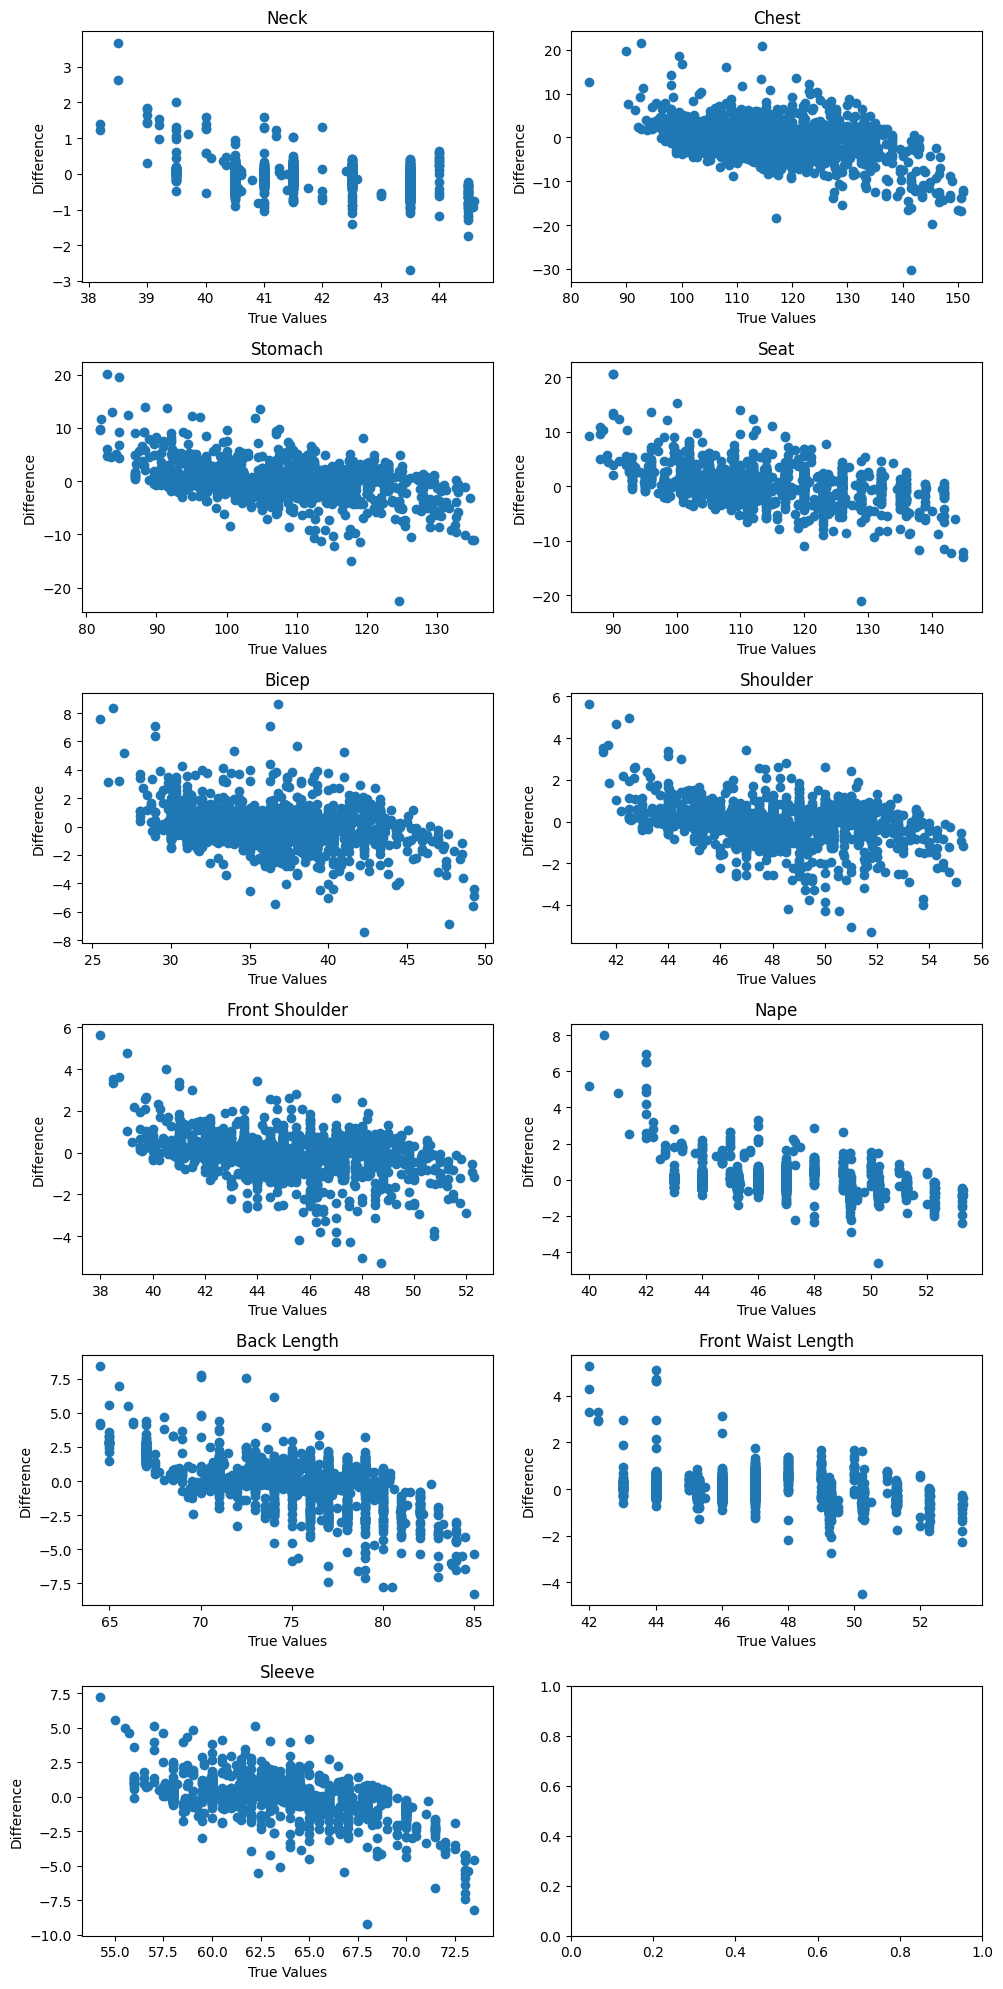

In [ ]:
from keras.backend import variable
delta=(model.predict(xj_test)-yj_test)

fig, axs = plt.subplots(6, 2, figsize=(10, 20))

for i,var in enumerate(delta.columns):
    row, col = divmod(i, 2)
    axs[row, col].scatter(yj_test[var], delta[var])
    axs[row, col].set_title(var)
    axs[row, col].set_xlabel('True Values')
    axs[row, col].set_ylabel('Difference')

plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()

76/76 [==============================] - 0s 3ms/step


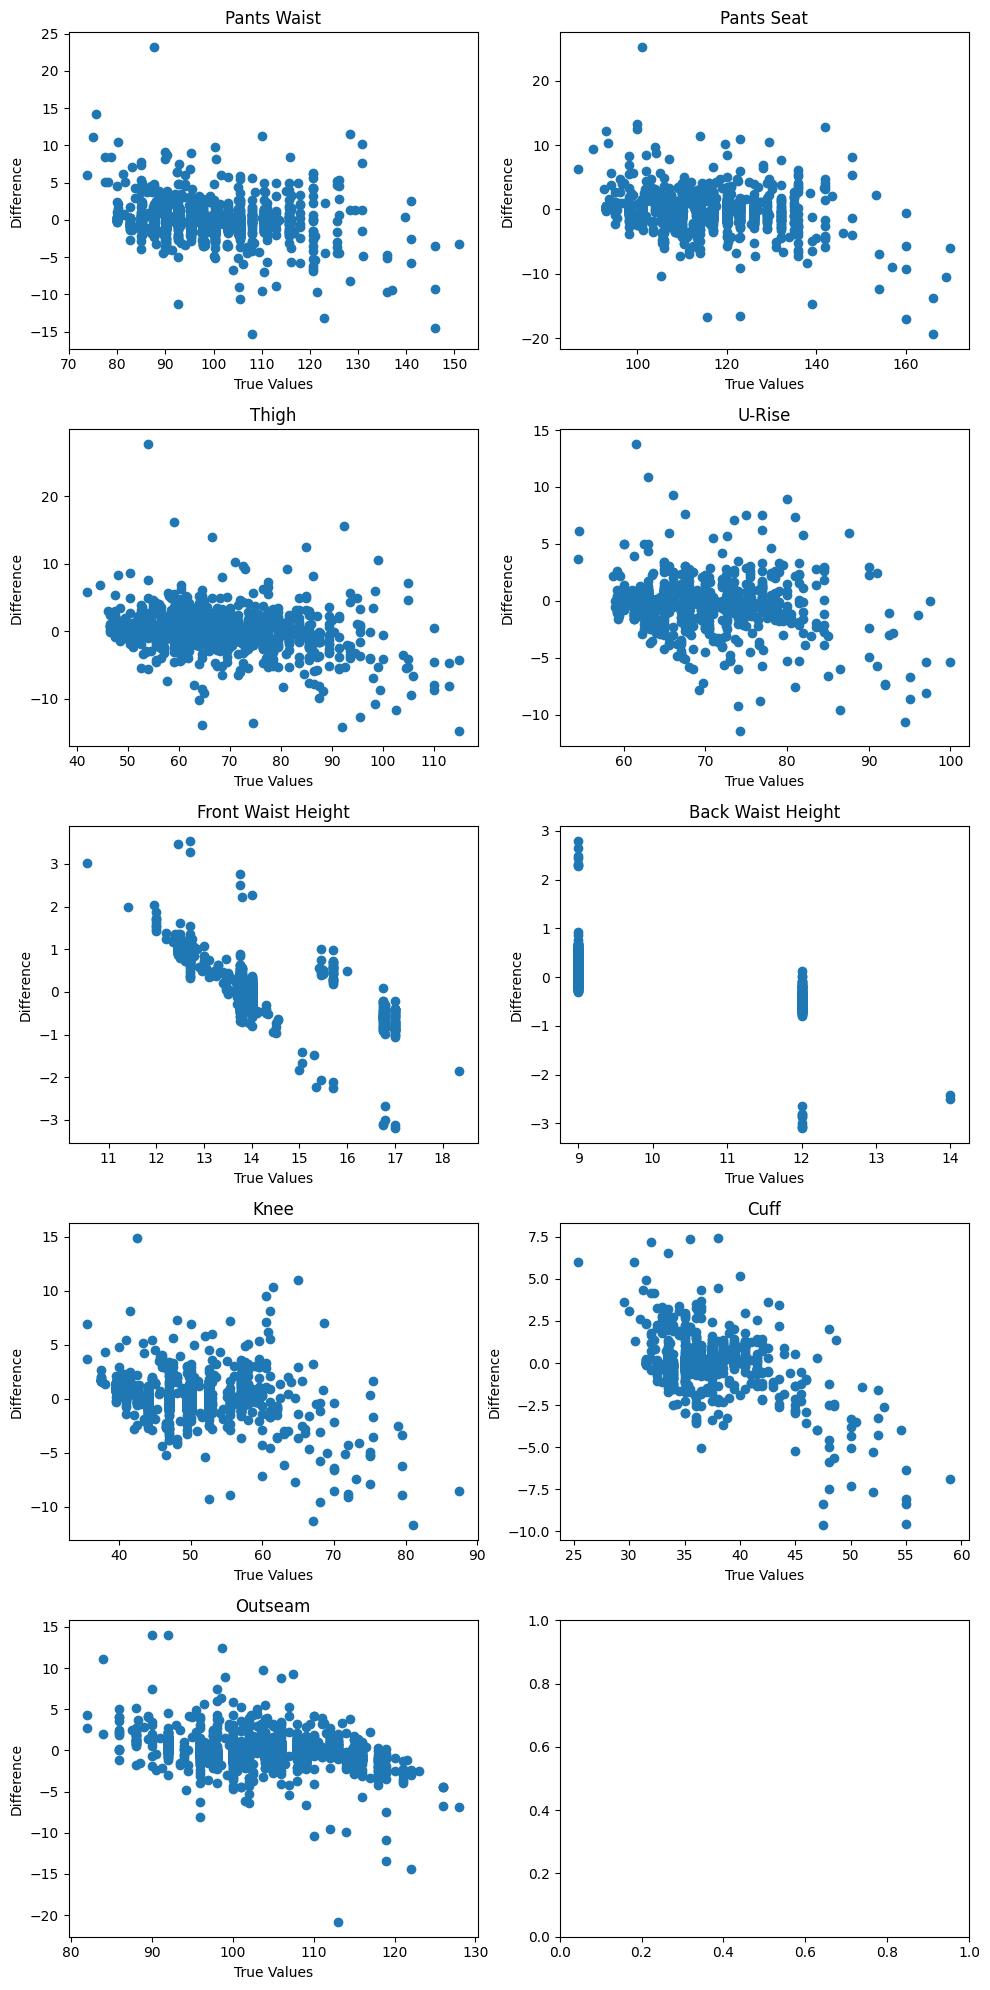

In [ ]:
from keras.backend import variable
delta=(pnt_mod.predict(xp_test)-yp_test)

fig, axs = plt.subplots(5, 2, figsize=(10, 20))

for i,var in enumerate(delta.columns):
    row, col = divmod(i, 2)
    axs[row, col].scatter(yp_test[var], delta[var])
    axs[row, col].set_title(var)
    axs[row, col].set_xlabel('True Values')
    axs[row, col].set_ylabel('Difference')

plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# # perform a grid search CV with more layers and hidden nodes
# # hidden layer=[4,8,16,32,64]
# # nodes = [32,64,128,256,512]
# from tqdm import tqdm_notebook
# res_struc = {}

# for hl in tqdm_notebook([1,2,3,4]):
#   for nd in tqdm_notebook([32,64,128,256,512,1024]):
#     # start the model without FC layer
#     model = Sequential([
#     ])
#     for i in tqdm_notebook(range(hl)):
#       model.add(
#           Dense(nd, activation = 'relu')
#       )

#     # add output layer
#     model.add(Dense(11, activation='linear'))
#     # check model
#     # model.summary()
#     # compile and fit
#     model.compile(tf.keras.optimizers.Adam(learning_rate = 0.001),
#                     loss = 'mse',
#                     metrics = [tf.keras.metrics.MeanAbsoluteError()])
#     history_gcv = model.fit(xj_train,yj_train, epochs=100, batch_size = 512, verbose = 1)

#     #
#     res_struc[(hl,nd)] = history_gcv.history['mean_absolute_error'][-1]

In [ ]:
# import pandas as pd
# res_struct_table = pd.DataFrame(pd.Series(res_struc))
# res_struct_table.columns = ['Accuracy']

# res_struct_table = res_struct_table.rename_axis(['Hidden Layers','Nodes'])

# # Display values in the center of each cell
# styled_df = res_struct_table.style

# # Apply CSS to center-align the text in cells
# styled_df = styled_df.set_properties(**{'text-align': 'center'})

# # find the model structure with the highest accuracy
# print(res_struct_table.idxmax())

# # Display the styled DataFrame
# styled_df